Copyright 2021 Regeneron Pharmaceuticals Inc. All rights reserved.

License for Non-Commercial Use of TCRAI code

All files in this repository (“source code”) are licensed under the following terms below:

“You” refers to an academic institution or academically employed full-time personnel only. 

“Regeneron” refers to Regeneron Pharmaceuticals, Inc.

Regeneron hereby grants You a right to use, reproduce, modify, or distribute the source code to the TCRAI algorithms, in whole or in part, whether in original or modified form, for academic research purposes only.  The foregoing right is royalty-free, worldwide, revocable, non-exclusive, and non-transferable.  

Prohibited Uses:  The rights granted herein do not include any right to use by commercial entities or commercial use of any kind, including, without limitation, any integration into other code or software that is used for further commercialization, any reproduction, copy, modification or creation of a derivative work that is then incorporated into a commercial product or service or otherwise used for any commercial purpose, or distribution of the source code not in conformity with the restrictions set forth above, whether in whole or in part and whether in original or modified form, and any such commercial usage is not permitted.  

Except as expressly provided for herein, nothing in this License grants to You any right, title or interest in and to the intellectual property of Regeneron (either expressly or by implication or estoppel).  Notwithstanding anything else in this License, nothing contained herein shall limit or compromise the rights of Regeneron with respect to its own intellectual property or limit its freedom to practice and to develop its products and product candidates.

If the source code, whole or in part and in original or modified form, is reproduced, shared or distributed in any manner, it must (1) identify Regeneron Pharmaceuticals, Inc. as the original creator, and (2) include the terms of this License.  

UNLESS OTHERWISE SEPARATELY AGREED UPON, THE SOURCE CODE IS PROVIDED ON AN AS-IS BASIS, AND REGENERON PHARMACEUTICALS, INC. MAKES NO REPRESENTATIONS OR WARRANTIES OF ANY KIND CONCERNING THE SOURCE CODE, IN WHOLE OR IN PART AND IN ORIGINAL OR MODIFIED FORM, WHETHER EXPRESS, IMPLIED, STATUTORY, OR OTHER REPRESENTATIONS OR WARRANTIES. THIS INCLUDES, WITHOUT LIMITATION, WARRANTIES OF TITLE, MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE, NON-INFRINGEMENT, ABSENCE OF LATENT OR OTHER DEFECTS, ACCURACY, OR THE PRESENCE OR ABSENCE OF ERRORS, WHETHER OR NOT KNOWN OR DISCOVERABLE. 

In no case shall Regeneron be liable for any loss, claim, damage, or expenses, of any kind, which may arise from or in connection with this License or the use of the source code. You shall indemnify and hold Regeneron and its employees harmless from any loss, claim, damage, expenses, or liability, of any kind, from a third-party which may arise from or in connection with this License or Your use of the source code. 

You agree that this License and its terms are governed by the laws of the State of New York, without regard to choice of law rules or the United Nations Convention on the International Sale of Goods.

Please reach out to Regeneron Pharmaceuticals Inc./Administrator relating to any non-academic or commercial use of the source code.

## TCRAI example : training a binomial classifier and inspecting TCRAI fingerprints

Let's load some TCR data, and build a TCRAI model from scratch - putting together the building blocks for all sections of the model for the various inputs: CDR3s and genes.

We'll then compile and train our model, and see how it performs on the left-out test set.

After training, we can inspect how the model positions TCRs input features in its fingerprint space, looking for clues of how the model extracted important features from the TCR data. As we discuss in the paper, by digging into the TCRAI fingerprint representation, one can uncover groups of TCR with different binding profiles.

Finally, we'll see how easy saving and loading TCRAI models is, as one doesn't need to know very much about the model at all to load and use it.

For the sake of simplicity we here use just one set of hyperparameters that we know work well, rather than cross-validating to select hyperparamters. The difference in the script without cross-validation, will affect random initialization and therefore the specific results achieved here vs in the manuscript.

In [1]:
import os
import sys
import tempfile
import io

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras as keras

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk',palette='bright')
import umap

from tcrai.modelling.processing import AASeqProcessor
from tcrai.modelling import extractors, closers
from tcrai.modelling.classification import SeqClassificationModelWithProcessor, VJXCRSeqModel
from tcrai.plotting import ml_plots
from tcrai.motif import dim_reduction,logo,motif_extraction

set up random seed initialization for consistency 

In [2]:
os.environ['PYTHONHASHSEED']=str(13)
np.random.seed(13)
tf.random.set_seed(13)

Provide a path to the data and load it

In [3]:
dataset = 'CNN-prediction-with-REGN-pilot-version-2'
data_root = os.path.join('..','data',dataset+'.csv')
df = pd.read_csv(data_root)

In this case, the data loaded has a column "id" which stores the peptide for the TCR, and we here will restrict ourselves to studying TCRs against one of these peptides. That is, we will build a binomial prediction model. After selecting from the dataset only rows where the "id" is for a specific peptide, we can then label whether these TCRs bind that peptide by using the values in the 'binds' columns, which has value 0 or 1, if it doesn't or does bind that peptide respectively.

In [4]:
df.id.unique() 

array(['IPSINVHHY', 'AVFDRKSDAK', 'GILGFVFTL', 'NLVPMVATV', 'IVTDFSVIK',
       'RAKFKQLL', 'GLCTLVAML', 'ELAGIGILTV', 'KLGGALQAK'], dtype=object)

In [5]:
df = df[df['id']=='GILGFVFTL']

In [6]:
df['labels'] = df['binds']

In order to prevent a TCR with the same genes and CDR3s does not appear in the train and test datasets, we first remove all duplicate TCRs

In [7]:
df = df.drop_duplicates(subset=['TRB_v_gene',
                                'TRB_j_gene',
                                'TRA_v_gene',
                                'TRA_j_gene',
                                'TRB_cdr3',
                                'TRA_cdr3'
                               ])

## Need processors to process the CDR3's

Since the CDR3s are strings, we need to convert these into numeric forms.

The processing module in tcrai.modelling provides processors for different tasks, and can be easily extended to new use cases.

Here, we use a simple processor, that converts each amino acid into an integer.

In [8]:
max_len_cdr3 = 40

processor_b = AASeqProcessor(max_len_cdr3)
processor_a = AASeqProcessor(max_len_cdr3)

seq_processors = {
    'TRB_cdr3': processor_b,
    'TRA_cdr3': processor_a
}

### Also, need to have processors/tokenizers for the gene info

Similarly, we need to convert the gene names into a numeric input. Again we use a dictionary type format to converts each unique gene to a unique integer. 1 is reserved for unknown gene types at test time. We perform the tokenization of the genes for each V and J gene.

In [9]:
vj_cols = ['TRB_v_gene','TRB_j_gene','TRA_v_gene','TRA_j_gene'] 
vj_tokenizers = dict()
for col in vj_cols:
    vj_tokenizers[col] = Tokenizer(filters='',lower=False,oov_token='UNK')
    vj_tokenizers[col].fit_on_texts(df[col])

#### Let's see how the processor's and the tokenizers work

In [10]:
processor_b.transform(['AVKPYYYGMDV','KPY'])

{'seqs': array([[ 2, 19, 10, 14, 21, 21, 21,  7, 12,  4, 19,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [10, 14, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)}

In [11]:
vj_tokenizers['TRB_v_gene'].texts_to_sequences(['TRBV29-1', 'TRBV12-4', 'UNKNOWN', 'BOB'])

[[11], [9], [1], [1]]

## We are also going to need models (blocks of layers) to create fingerprints for each input

The extractors module provides a few simple extractor blocks, which return tensorflow keras models. Here, we use the conv_seq_extractor to make a keras model to convert numerical CDR3 inputs into 1d fingerprint vectors. 

In [12]:
seq_encoder_params = {
    'embed_dim': 16,
    'filters': [64,128,256],
    'kernel_widths': [5,4,4],
    'dilations': [1,1,1],
    'strides': [1,3,3],
    'L2_conv': 0.01,
    'dropout_conv': 0.3,
}

seq_encoders = {
    'TRB_cdr3': extractors.conv_seq_extractor(seq_encoder_params,
                                              max_len_cdr3,
                                              seq_processors['TRB_cdr3'].vocab_size),
    'TRA_cdr3': extractors.conv_seq_extractor(seq_encoder_params,
                                              max_len_cdr3,
                                              seq_processors['TRA_cdr3'].vocab_size)
}

#### now, gene encoders

We can use vj_extractor to build keras models for encoding the gene inputs into fingerprint vectors

In [13]:
vj_encs = dict()
embed_dim = {
    'TRB_v_gene': 16,
    'TRB_j_gene': 8,
    'TRA_v_gene': 16,
    'TRA_j_gene': 8
}

for v in embed_dim.keys():
    hp_vj={
        'vj_width':len(vj_tokenizers[v].word_index) +1,
        'vj_embed': embed_dim[v],
        'dropout': 0.3
    }
    vj_encs[v] = extractors.vj_extractor(hp_vj,name=v+'_enc')

## We also need a `closer`, which will take all the fingerprints, and create a final model ouput

Closer functions return models which take concatenated fingerprint vectors of all input extraction fingerprints, and make a final output. In this case we use "make_predictor", which makes a single sigmoid output prediction (on [0,1]) -  a probability that this TCR binds the given peptide. Closer methods are also provided for regression and multinomial predictions.

In [14]:
hp_pred = {
    'units': [],
    'dropout': 0.3,
    'L2_dense': 0.0,
    'init_bias': 0.0
}

predictor = closers.make_predictor(hp_pred)

### Now build our model

We use a tcrai.modelling.classification.VJXCRSeqModel as our underlying tf.keras model.

This model takes the encoders we made above, for the sequences and for the genes, and the final closer model.

We can optionally restrict the model to only use a subset of the inputs, via the input_list option. Since the encoders are given as dictionaries, with the keys being the names of the inputs, we don't need to know which order the inputs came in, we can simply provide a list of the input names that we want to be included in the model. This allows one to easily adjust the type of model one uses during say a loop.


In [15]:
model0 = VJXCRSeqModel(seq_encoders,
                       vj_encs,
                       predictor,
                       input_list=None # could choose to only include certain keyed inputs, e.g. ['TRB_v_gene','TRB_j_gene','TRB_cdr3'] for a beta chain model
                      )

### Now put this model inside a model with processors

The model we just created above is a tf.keras.Model subclass, and hinges a lot on the underlying methods of that class. We also want to be able to process our input data with our processors, and later save all those objects together, so that the user doesn't need to know how the model was built, or how inputs are processed. 

In [16]:
model = SeqClassificationModelWithProcessor(model0, processors=seq_processors, extra_tokenizers=vj_tokenizers)

## Let's now prepare our input data

Easy enough - the model just wants list of input data in a dictionary - with the keys as the (sensible) names we gave our encoders/processors

In [17]:
def df_to_input(df):
    """ convert a dataframe into a dictionary of inputs """
    cols = ['TRB_v_gene','TRB_j_gene','TRA_v_gene','TRA_j_gene','TRB_cdr3','TRA_cdr3']
    x = { c:df[c].values for c in cols}
    return x

We can split our input data first into train/validaton/test sets

In [18]:
tr_df,test_df,y_tr,y_test = train_test_split(df,
                                            df['labels'],
                                           test_size=0.1,
                                           stratify=df['labels'],
                                           random_state=42)

train_df,vali_df,y_train,y_vali = train_test_split(tr_df,
                                            tr_df['labels'],
                                           test_size=0.2,
                                           stratify=tr_df['labels'],
                                           random_state=42)


In [19]:
train_input = df_to_input(train_df)
vali_input = df_to_input(vali_df)
test_input = df_to_input(test_df)

### We can now compile, and fit our data

Because we subclassed a tf.keras.Model, we can easily compile, fit etc

In [20]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [keras.metrics.AUC(name='ROC')]
)

#### data is imbalanced, before we train, let's weight our loss appropriately

In [21]:
weights = compute_class_weight('balanced',classes=np.arange(2),y=np.squeeze(y_train))
print(weights)

[0.61189125 2.73431242]


Keras makes it easy to implement early stopping: If the validation loss starts to increase - stop training as we're overfitting

In [22]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True )

In [23]:
history = model.fit(train_input, y_train,
          validation_data = (vali_input, y_vali),
            epochs = 250,
            callbacks = [early_stop],
            class_weight =  {i:weights[i] for i in range(len(weights))},
            batch_size = 256,
            verbose = 0
)

### Now we've trained our model - let's see how it performs

we can add evaluators to our model, and then get all evaluations out with a call to 'evaluate'

In [24]:
model.add_evaluator(metrics.roc_auc_score,'roc')

In [25]:
model.evaluate(test_input,y_test)

{'roc': 0.9548530868273358}

#### See how training progressed over epochs over the dataset

we can see that training stopped when validation loss started to increase, avoiding overfitting

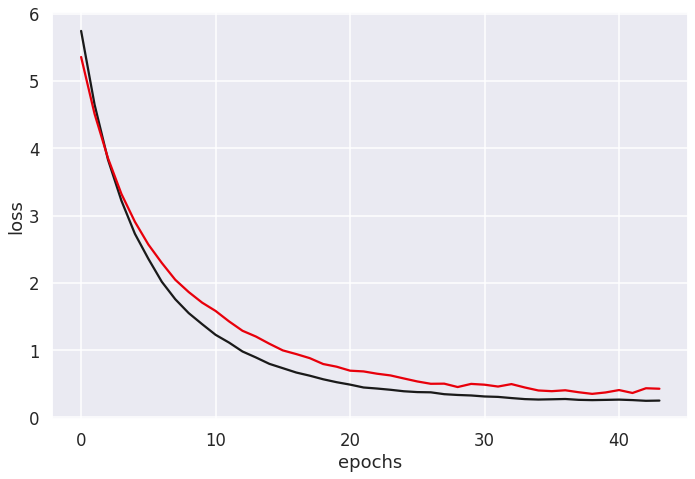

In [26]:
ml_plots.plot_loss(history)

### Check the ROC performance of the classifier

In [27]:
preds = model.run(test_input)

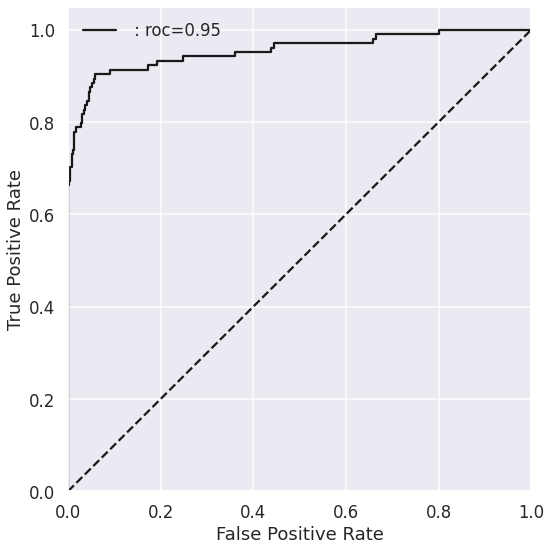

In [28]:
ml_plots.plot_roc_binomial(y_test,preds)

## Analyzing TCR fingerprints

Recall that we combine the encoded vectors from all our inputs into a single vector - we can look at how that vector clusters for all our samples

The XCR model class provides an easy way to do this - via its calculate_z method

All subclasses inherit this behaviour automatically

In [29]:
def plot_umap(input_data,y,model,selection=None):
    z = model.calculate_z(input_data,selection=selection)
    umapper = umap.UMAP(random_state=42)
    z_2d = umapper.fit_transform(z)
    
    preds = np.squeeze(model.run(input_data))
    
    inds = np.logical_and(preds>0.95,y)
    
    f,ax = plt.subplots(1,1,figsize=(7,7))
    
    plt.scatter(z_2d[np.logical_not(inds),0],
                z_2d[np.logical_not(inds),1],
                c='k',
                s=3,
                alpha=0.1,
                label='non-binder or weak prediction'
    )
    plt.scatter(z_2d[inds,0],
                z_2d[inds,1],
                c='r',
                s=6,
                alpha=0.8,
                label='Strong True Positive'
    )
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.xticks([])
    plt.yticks([])
    
    plt.legend(bbox_to_anchor=(0.1, -0.26), loc='lower left')
    
    plt.tight_layout()

In [30]:
sns.set_style("whitegrid")

Setting selection=None will calculate the fingerprint based on all input fingerprints: e.g. both CDRs, and all genes

/data/home/peter.hawkins/.conda/envs/tcrai_logo/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


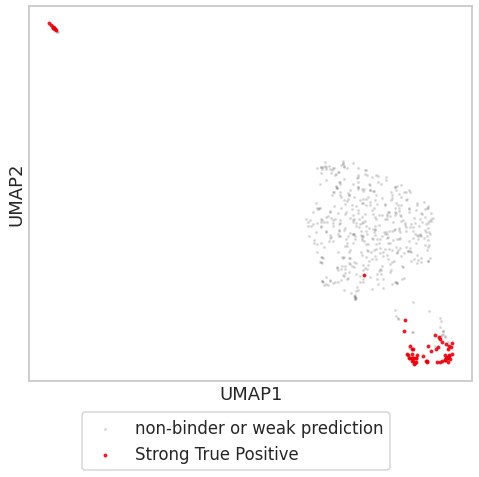

In [31]:
plot_umap(test_input,y_test,model,selection=None)

We can also look at how just the beta chain CDR3 fingerprints are distributed, or indeed, any subset of the input fields - just put the ones you want to consider into a list

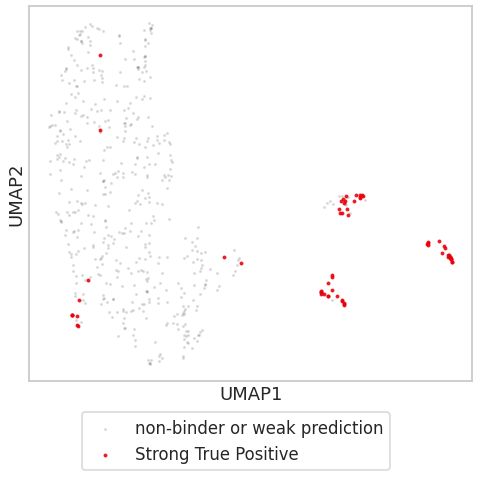

In [32]:
plot_umap(test_input,y_test,model,selection=['TRB_cdr3'])

### Further analysis

One can extend this analysis by clustering the strong true positives that are identified, and investigate conserved motifs in the clusters.

Let's first use UMAP to reduce fingerprints of TCRs in the full dataset (train,test and validation) to 2D

We'll use the ScaledXCRUmap from the tcrai.motif.dim_reduction, which is designed to help facilitate umap on dataframes of TCR data and a TCRAI model, to perform the UMAP procedure.  

In [33]:
umapper = dim_reduction.ScaledXCRUmap(model,
                                      df_to_input,
                                      scaler=None,
                                      selection=None
                                     )
z_umap = umapper.fit_transform(df)

### Cluster the fingerprints of the Strong True Positives

cluster those TCRs that bind, and have prediction probability > 0.95

Select the number of clusters that has the lowest Silhouette score


In [34]:
def apply_optimal_clustering(z,df,threshold=0.5):
    
    z_binders = z[(df['binds']==1) & (df['preds']>threshold)]
    tcr_ids = df[(df['binds']==1) & (df['preds']>threshold)]['TCR_id']
    
    labels = np.zeros((len(z_binders,)))
    best_score = -2
    for n in range(2,8):
        kmeans = KMeans(n_clusters= n,
                       random_state=42)
        tmp_labels = kmeans.fit_predict(z_binders)
        score = metrics.silhouette_score(z_binders,tmp_labels)
        if score>best_score:
            best_score = score
            labels = tmp_labels
    
    print("selected ", np.amax(labels)+1, " clusters")
    label_df = pd.DataFrame({'TCR_id': tcr_ids, "cluster": labels})
    df_out = df.join(label_df.set_index('TCR_id'),on='TCR_id')
    return df_out

In [35]:
df['preds'] = model.run(df_to_input(df))
df_clustered = apply_optimal_clustering(z_umap,df,threshold=0.95)
n_clusters = int(df_clustered['cluster'].max()+1)

selected  2  clusters


### Plot the clusters of fingerprints

In [36]:
def plot_clustered_umap(z_train_umap,
                        train_df):
    
    bkg_col = 'k'
    COLS = ['darkorange',
           'seagreen',
           'gold',
           'blueviolet',
           'deeppink',
           'indianred',
           'yellow',
           'lawngreen'
    ]

    f,ax = plt.subplots(1,1,figsize=(12,7))

    ax.scatter(z_train_umap[train_df.cluster.isna(),0],
               z_train_umap[train_df.cluster.isna(),1],
               c=bkg_col,
               s=1,
               alpha=0.1,
               label = 'nonbinder or \n weak prediction'
            )
    for c_idx in range(int(train_df['cluster'].max()+1)):
        this_df = train_df[train_df['cluster']==c_idx]
        if len( this_df )>9:
            ax.scatter(z_train_umap[train_df['cluster'].values==c_idx,0],
                        z_train_umap[train_df['cluster'].values==c_idx,1],
                        c=COLS[c_idx],
                        s=3,
                        alpha=0.5,
                        label = 'cluster '+str(c_idx)
                    )
        else:
            ax.scatter(z_train_umap[train_df['cluster'].values==c_idx,0],
                        z_train_umap[train_df['cluster'].values==c_idx,1],
                        c=COLS[c_idx],
                        s=1,
                        alpha=0.1
                    )
    
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.xticks([])
    plt.yticks([])

    plt.legend(bbox_to_anchor=(1.0, 0.6), loc='lower left')

    plt.tight_layout()
    return None

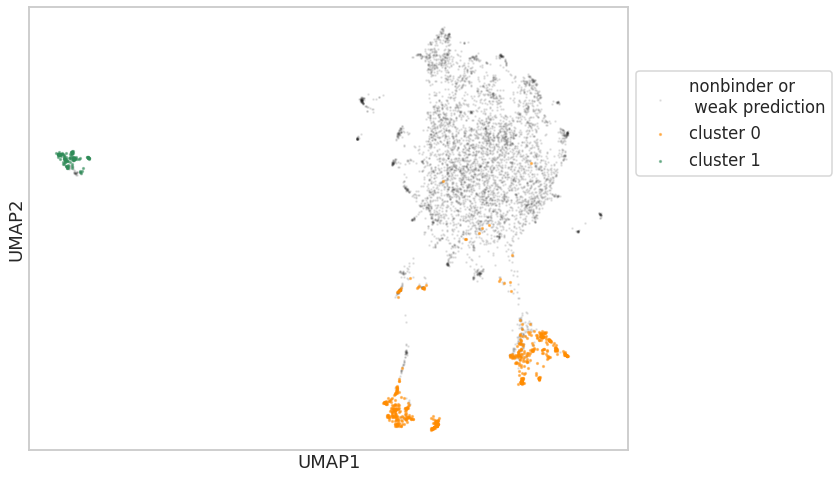

In [37]:
plot_clustered_umap(z_umap,df_clustered)

### For each cluster - collect the TCR CDR3 regions, and extract motif of these

We first save a temporary fasta file of IMGT aligned CDR3s for paired alpha and beta chains in each cluster

Then we use some functions from the tcrai.motif subpackage to generate a fasta of CDR3s in each motif and motif weblogo image for each CDR3 chain.


In [38]:
def cluster_logo_image(df, c_idx, chain='TRB_cdr3'):
    cdr_df = df[df['cluster']==c_idx][['TCR_id',chain]]
    with tempfile.TemporaryDirectory() as tmpdirname:
        fasta_file = os.path.join(tmpdirname,'tmp_fasta.fasta')
        motif_extraction.cdr3s_to_fasta(cdr_df['TCR_id'].map(lambda x: str(x)).values,
                                        cdr_df[chain].values,
                                        fasta_file)
        png = logo.create_logo_png(fasta_file,
                                   title = None,
                                   units='probability')
    image = Image.open(io.BytesIO(png))
    return image

In [39]:
ims = []
c_idx_list = []
for c_idx in range(n_clusters):
    tmp_ims = []
    this_df = df_clustered[df_clustered['cluster']==c_idx]
    if len(this_df)>9:
        tmp_ims.append( cluster_logo_image(df_clustered, c_idx, chain='TRA_cdr3') )
        tmp_ims.append( cluster_logo_image(df_clustered, c_idx, chain='TRB_cdr3') )
        ims.append(tmp_ims)
        c_idx_list.append(c_idx)

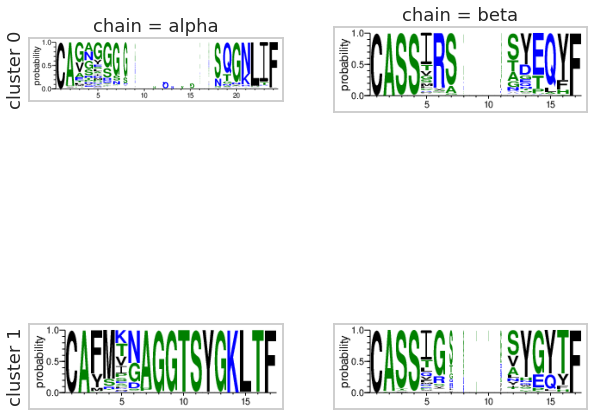

In [40]:
chain_names = ['alpha','beta']
f,axes = plt.subplots(len(ims),2,figsize=(10,10))
for c_idx in range(len(ims)):
    for chain in [0,1]:
        if len(ims)==1:
            idxs = (chain)
        else:
            idxs = (c_idx,chain)
        axes[idxs].imshow(ims[c_idx][chain])
        axes[idxs].set_xticks([])
        axes[idxs].set_yticks([])
        if chain==0:
            axes[idxs].set_ylabel('cluster '+str(c_idx_list[c_idx]))
        if c_idx==0:
            axes[idxs].set_title('chain = '+str(chain_names[chain])  )

### Comparison with the results in the manuscript

We see that training with one set of hyperparameters, without cross-validation, leads to a slightly different outcome, but with broadly the same scientific outcome.

The model ROC test-set performance of 0.955 is very similar to that in the manuscript.

Though the fingerprint space is slightly modified from the manuscript we still find that the so-called Group II TCRs are in a distinct cluster (cluster 2), and the canonical group I TCRs are in another. 

## Easily save and load the model

let's do this in a temporary directory, for the sake of the notebook we do not need to permanently save to disk. In practice, one may wat to save the model to disk, and later use it to classify new TCRs, or to investigate TCRAI fingerprint structure after training and saving a model.

#### loaded model used as before

Note, we don't have to know anything about the hyperparameters or architecture of the model.
We can use this model on the test data and see it performs as before

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpvd4leq_i/model/assets
 

 model evaluation :  {'roc': 0.9548530868273358}
 

 


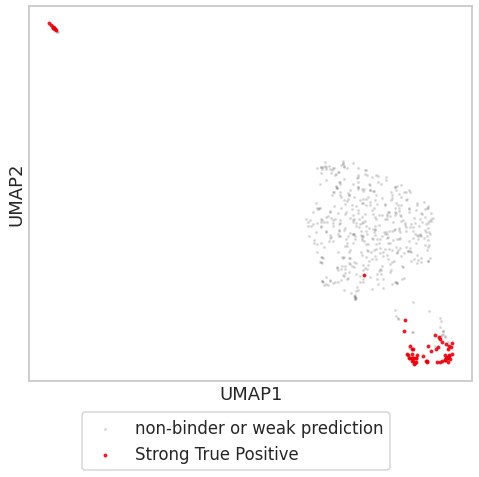

In [41]:
with tempfile.TemporaryDirectory() as tmpdirname:
    model.save(tmpdirname)
    
    # now load the saved model, from (tempoarary) file, into notebook
    loaded_model = SeqClassificationModelWithProcessor.from_file(tmpdirname)
    
    # check the model ROC is the same as before
    loaded_model.add_evaluator(metrics.roc_auc_score,'roc')
    print(" \n\n model evaluation : ",loaded_model.evaluate(test_input,y_test))
    print(" \n\n ")
    # check the UMAP is the same as before
    plot_umap(test_input,y_test,loaded_model,selection=None)
    
    